In [117]:
from importlib import reload
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, root
import axion_motion
import model
import transport_equation
import reheating
from common import cosmology, constants, util
from common.rh_neutrino import calc_Gamma_a_SU2
from transport_eq import model as rad_dom_model
from transport_eq import axion_motion as rad_dom_axion_motion
from axion_leptogenesis import model as original_model

In [14]:
T_RH = 1e12
decay_rate = 0 # cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_dec))
Gamma_phi = cosmology.calc_inflaton_decay_rate_from_reheating_temperature(T_RH)
print(f"Gamma_phi(T_RH) = {Gamma_phi:.2e}")
H_inf = 1e12 

Gamma_phi(T_RH) = 2.50e+06


In [28]:
%time ress_good = model.solve_to_end(m_2, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=5e-5)
%time ress2_good = rad_dom_model.solve_to_end(m2_2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=4e11, collect=True)

CPU times: user 686 ms, sys: 12 µs, total: 686 ms
Wall time: 684 ms
CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.37 s


In [15]:
m_a = 1e6
m_2 = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2_2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

<ipython-input-152-daa8939c7ccb>:58: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_xticklabels(good_names, Rotation=50, fontsize=12)


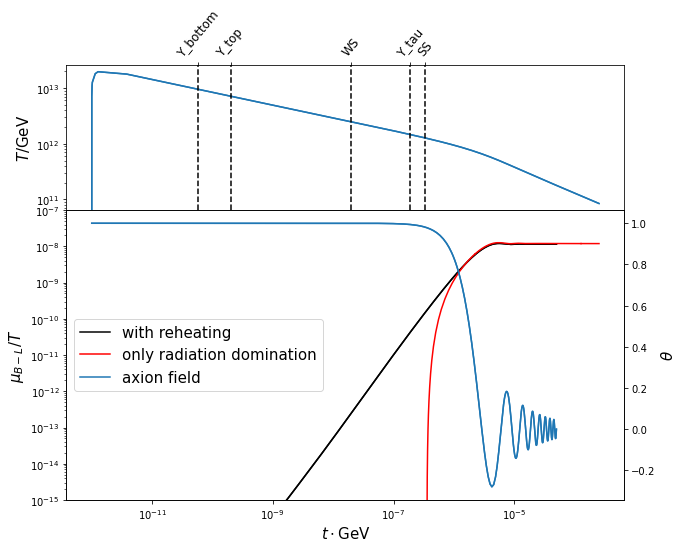

In [152]:
def plot(ress, ress2, filename=None):
    fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(10,8), gridspec_kw=dict(height_ratios=[1, 2]))
    fig.subplots_adjust(hspace=0)
        
    for i, res in enumerate(ress):        
        l1, = ax1.loglog(res.t, -transport_equation.calc_B_minus_L(res.red_chem_pots), 
                   color="black", label="with reheating" if i == len(ress) - 1 else None)
        
    for i, res2 in enumerate(ress2):
        t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
        l2, = ax1.loglog(t, -transport_equation.calc_B_minus_L(res2.red_chem_pots), 
                   color="red", label="only radiation domination" if i == len(ress2) - 1 else None)
    
    ax_sec = ax1.twinx()
    for i, res in enumerate(ress):
        l3, = ax_sec.semilogx(res.t, res.axion_fn(np.log(res.t))[0], 
                        label="axion field" if i == len(ress) - 1 else None, color="tab:blue")
        
    ax1.set_ylim(1e-15, 1e-7)
    ax1.set_ylabel(r"$\mu_{B - L} / T$", fontsize=15)
    
    ax_sec.set_ylabel(r"$\theta$", fontsize=15)
    
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="center left", fontsize=15)
    
    for i, res in enumerate(ress):
        ax2.loglog(res.t, res.T_fn(res.t), color="tab:blue")
                
    ax1.set_xlabel(r"$t \cdot \mathrm{GeV}$", fontsize=15)
    ax2.set_ylabel(r"$T / \mathrm{GeV}$", fontsize=15)
    
    ax2.xaxis.tick_top()
    T_max = max([np.max(res.T_fn(res.t)) for res in ress])
    T_min = min([np.min(res.T_fn(res.t)) for res in ress])
    t_eqs = []
    for T_eq in model.T_eqs:
        if T_min > T_eq  or T_eq > T_max:
            continue
        for res in ress:
            try:
                res = root(lambda log_t: np.log(res.T_fn(np.exp(log_t)) / T_eq), 
                           (np.log(res.t[0]) + np.log(res.t[-1])) / 2
                )
                if res.success:
                    t_eq = np.exp(res.x[0])
                    t_eqs.append(t_eq)
                    ax2.axvline(t_eq, color="black", ls="--")
                    break
            except Exception as e:
                print(e)
        else:
            t_eqs.append(None)
    good_names = [n for n, t_eq in zip(transport_equation.process_names, t_eqs) if t_eq is not None]
    good_t_eqs = [t_eq for t_eq in t_eqs if t_eq is not None]
    ax2.set_xticks(good_t_eqs)
    ax2.set_xticklabels(good_names, Rotation=50, fontsize=12)            
    
    if filename is not None:
        plt.savefig(util.make_plot_path(filename))
    
    plt.show()
    
plot(ress_good, ress2_good, "rh_vs_raddom_good_case.pdf")

In [140]:
len(transport_equation.process_names), len(model.T_eqs)

(7, 7)

In [5]:
m_a = 1e10
m = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

In [6]:
%time ress = model.solve_to_end(m, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=5e-6)
%time ress2 = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=4e11, collect=True)

KeyboardInterrupt: 

In [ ]:
plot(ress, ress2, "rh_vs_raddom_bad_case.pdf")

In [ ]:
roots = lambda theta: np.sum(np.sign(theta[:-1]) != np.sign(theta[1:]))
sum([roots(res.axion[0]) for res in ress])

In [ ]:
m_a_range = np.geomspace(1e6, 1e9, 21)
Gamma_phi_range = np.geomspace(1e6, 1e9, 20)
H_inf = 2e10
f_a = 3e14

In [ ]:
%%time
def f(m_a, Gamma_phi):
    start_time = time.time()
    print(f"starting m_a = {m_a:.2e}, Gamma_phi = {Gamma_phi:.2e}", end="")
    ans = model.solve(model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                                           axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,), Gamma_phi, H_inf),
                              (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass)
    end_time = time.time()
    print(" done in", end_time - start_time, "seconds")
    return ans
eta_B_rh = [[f(m_a, Gamma_phi) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

In [ ]:
%%time
eta_B_rad_dom = [[rad_dom_model.solve(rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                                                      rad_dom_axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,)), 
                                 cosmology.calc_reheating_temperature(Gamma_phi), (1,0), f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
                for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

In [ ]:
%%time
eta_B_original = [[original_model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

In [ ]:
fname = "background_cosmology_comparison.pkl"
#util.save_data(fname, m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh)
#m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh = util.load_data(fname)

In [ ]:
levels = np.hstack([np.arange(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
          1), np.log10(constants.eta_B_observed)])
levels.sort()

CS = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rad_dom), levels)
plt.colorbar().set_label(r"$\log_{10} (\eta_B^0)$", fontsize=15)
CS.collections[np.where(CS.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS2 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rh), levels, linestyles="--")
CS2.collections[np.where(CS2.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS3 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_original), levels, linestyles=":")
CS3.collections[np.where(CS3.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

plt.title(f"f_a = {f_a:.2e} GeV", fontsize=15)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$m_a$ / GeV", fontsize=15)
plt.ylabel(r"$\Gamma_\phi$ / GeV", fontsize=15)
h1, _ = CS.legend_elements()
h2, _ = CS2.legend_elements()
h3, _ = CS3.legend_elements()
plt.legend([h1[0], h2[0], h3[0]], ["pure rad. dom.", "reheating", "original"], framealpha=1.0, loc=4)
plt.tight_layout()
plt.savefig(util.make_plot_path("rad_dom_vs_rh_parameter_space.pdf"))

In [ ]:
t_start, init = reheating.calc_initial_reheating(H_inf)
t_end = 1e3*cosmology.switch_hubble_and_time_rad_dom(
    cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(cosmology.calc_reheating_temperature(Gamma_phi))))
T_fn, H_fn, T_dot_fn, _ = reheating.solve_reheating_eq(t_start, t_end, init, Gamma_phi)
ts = np.geomspace(t_start, t_end, 300)

In [ ]:
def axion_jac(t, y):
    theta, theta_dot = y
    H = H_fn(t)
    T = T_fn(t)
    return np.array([
        [0,                                                     -1],
        [- axion_motion.calc_d2Vdtheta2_simple(T, theta, m_a), -3*H]
    ])

In [ ]:
from numba import njit

In [ ]:
type(T_fn)

In [ ]:
%%time

m_a = 1e10

def rhs(log_t, y):
    theta, v = y
    t = np.exp(log_t)
    T = T_fn(t)
    H = H_fn(t)
    return (
        v * t,
        (- 3 * H_fn(t) * v - m_a**2 * theta) * t
    ) 

sol = solve_ivp(rhs, (np.log(t_start), np.log(5e-6)), (1, 0), dense_output=True, rtol=1e-3)

In [ ]:
plt.l

In [ ]:
theta = sol.sol(sol.t)[0]

In [ ]:
plt.plot(sol.t, theta)

In [ ]:
theta_dot = sol.sol(sol.t)[1]
c = theta + theta_dot/m_a*1j
a = np.angle(c)
r = np.abs(c)

In [ ]:
plt.loglog(sol.t, r)
plt.loglog(sol.t, a)

In [ ]:
plt.plot(theta, theta_dot/m_a)